## Notebook to fine tune XGB Model  File No:3

**This notebook predicts LOS Range given patient demographics, primay Diagnosis, Diagnosis category and comorbidities**

### Step 1: Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import time

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import *

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

### Step 2: Load the data file

In [2]:
rawdata = pd.read_csv('data/DiagVsLOSRangev3.csv', index_col=[0])

data = rawdata

### Step 3 Preprocess the data for the model 

In [3]:
#Drop text column DiagDesc 
data.drop(columns='DiagDesc', inplace=True)

#encode categorical columns
CatgCols = ['Gender', 'Ethinicity', 'Religion', 'MaritalStatus',
       'DiagnosisCategory', 'PrimaryDiag', 'DiagGroup']

le = preprocessing.LabelEncoder()
data = rawdata
data[CatgCols].values.flatten()
le.fit(data[CatgCols].values.flatten().astype(str))
data[CatgCols] = le.transform(data[CatgCols].values.flatten().astype(str)).reshape(data[CatgCols].shape)

# encode predictor variable
lep = preprocessing.LabelEncoder()
lep.fit(data.LosRange)
lep_dict = dict(zip(lep.classes_, lep.transform(lep.classes_)))
print(lep_dict)
data.LosRange = lep.transform(data.LosRange)


{'0:<7': 0, '1:8-14': 1, '2:15-30': 2, '3:31-60': 3, '4:61-120': 4, '5:121-180': 5, '6:180+': 6}


**Choose target and unused columns in the dataset**

In [4]:
## Ignore the first three columns (LosRange, EntitySys, TotalLOS and )
target='LosRange'
NonFeatureCols =['LosRange','EntitySys','TotalLos','DiagDesc',
                 'Religion','Ethinicity']   # always include predictor
featureList = [x for x in data.columns if x not in NonFeatureCols]

### Step 4 Split Train and Test Data sets for validating the model

In [5]:
# Create matrices and dataframes for train/test
X = data[featureList]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

### Import Functions for use in tuning the model

In [6]:
import XGBFunctions as myf
#imports the following functions
#   printPredictions(alg, X, y, featureList):
#   printResults(alg, X, y, featureList):
#   modelfit(alg, xtrain, ytrain, target, featureList,useTrainCV=True, 
#            cv_folds=5, early_stopping_rounds=50):
#   printModelStats(model, dtrain, dtest, featureList, target):
#   save_tree(xgb_model, filename, rankdir='UT'):
#   show_tree(model):

### Do not edit above code

**Run based on values from previous model**


Model Report
Accuracy  : 0.8842
Precision : 0.8966
Recall    : 0.8631
Balanced Accuracy  : 0.8631
Precision(wtd) : 0.8871
Recall(wtd)    : 0.8842
Balanced Accuracy(adj)  : 0.8403
Model Fit Time 01h:34m:26s


Training Predictions
Accuracy: 88.42%
Precision Score: 0.89665
Recall: 0.86313
[[1073    4   12   17    8    4   23]
 [  40  466    6    4    8    7   20]
 [  29    2  563    9   11    3   19]
 [  30    5    8  558    7    0   30]
 [  29    8   11   12  512    3   29]
 [  21    5    8    6   10  216   31]
 [  26    9   13   11    8    0  781]]
Test Predictions
Accuracy: 26.91%
Precision Score: 0.21074
Recall: 0.21851
[[189  39  48  43  30  10  36]
 [ 77  31  32  24  23   5  22]
 [ 69  26  32  18  30   6  28]
 [ 56  20  24  27  23   9  37]
 [ 61  11  28  21  32   8  39]
 [ 30   8  13  15  11   2  27]
 [ 41  10  19  31  30  11 110]]
Number of Trees 1400


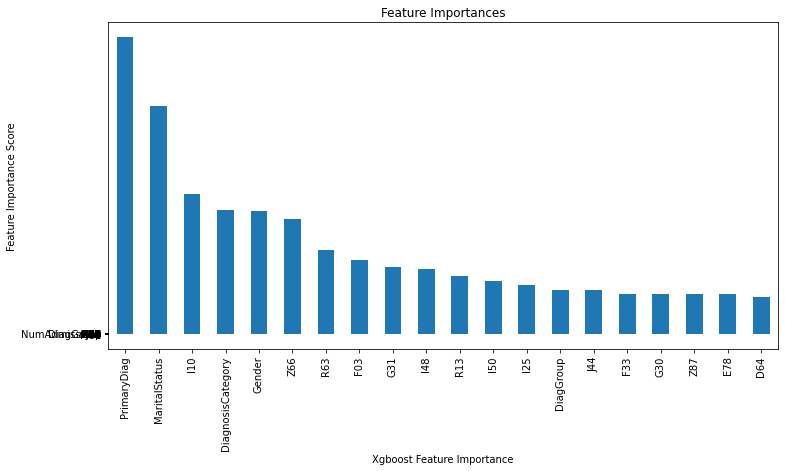

In [9]:
# same as xgb7 with gender and marital status
# boosting rounds from 500 to 300, depth from 20 to 15, tree_method from exact to approx,
# xgb8 showed no improvement.
# Result:
# Training Accuracy from 95.31% to ??
# Test Accuracty from 27.35% to ??
# Number of trees from 3500 to 
# Note: Start changing the structure of the tree

xgb9 = XGBClassifier(
    n_estimators=300,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 18,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'dart',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma=0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,              # sample observations for each tree 1 means all
    colsample_bytree= 1,       # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=80,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly 
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'approx',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1,
    nthreads=4
)
start_time = time.time()
myf.modelfit(xgb9, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
myf.printModelStats(xgb9, dtrain, dtest, featureList, target)

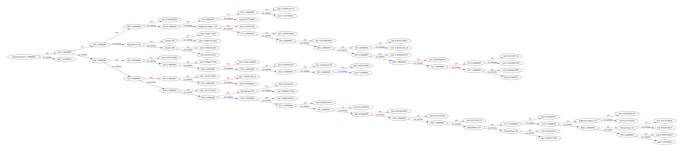

In [8]:
myf.show_tree(xgb9)

In [ ]:
xgb